In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow.keras import layers
from tensorflow.keras import losses

In [3]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

In [4]:
dataset = tf.keras.utils.get_file("stack_overflow_16k", url, untar=True, cache_dir='.', cache_subdir='')

In [5]:
!ls

README.md  stack.ipynb	stack_overflow_16k.tar.gz  test  train


In [6]:
train_dir = os.path.join('train')

In [7]:
!ls train

csharp	java  javascript  python


In [8]:
os.listdir(train_dir)

['python', 'java', 'csharp', 'javascript']

In [9]:
sample_file1 = os.path.join(train_dir, 'java/1.txt')

In [10]:
with open(sample_file1) as f:
    print(f.read())

"add version to @@webservice i'm using blankx.jws.webservice to create my webservice, in addition to targetnamespace i would like to include a ""version"" attribute to mark the version of my service. what other tag can i use in addition to this one to accomplish this so my wdsl will look like:..&lt;schema targetnamespace=""http://example.com/2009/02/15/webservice"" version=""1.1"" xmlns=""http://www.w3.org/2000/10/xmlschema&gt;...i.e. it has a version attribute"



In [11]:
sample_file2 = os.path.join(train_dir, 'python/1755.txt')
with open(sample_file2) as f:
    print(f.read())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



In [12]:
sample_file3 = os.path.join(train_dir, 'javascript/17.txt')
with open(sample_file3) as f:
    print(f.read())

"replace prototype dynamically by changing constructor property i am trying to make some good code example to experience blank's ""classlessness"". this is what i have come up with so far:..function one() {}.function two() {}..one.prototype.a = 5;.two.prototype.b = 4;..var obj = new one();.print(""1) ctor ="", obj.constructor, ""a ="", obj.a, "" b ="", obj.b);.obj.constructor = two;.print(""1) ctor ="", obj.constructor, ""a ="", obj.a, "" b ="", obj.b);..var objtwo = new obj.constructor();.print(""2) ctor ="", objtwo.constructor, ""a ="", objtwo.a, "" b ="", objtwo.b);...and these are corresponding prints:..1) ctor = function one() {.} a = 5  b = undefined.1) ctor = function two() {.} a = 5  b = undefined.2) ctor = function two() {.} a = undefined  b = 4...my question is why prototype chain does not work here by the book? i run my example in ideone with blank (spidermonkey) (spidermonkey-1.7). it looks like in real life prototype is accessed somehow else than constructor.prototype?..p.

In [97]:
batch_size = 16
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.20, subset='training', seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [98]:
# print("Label 0 corresponds to", raw_train_ds.class_names[0])
# print("Label 1 corresponds to", raw_train_ds.class_names[1])
# print("Label 2 corresponds to", raw_train_ds.class_names[2])
# print("Label 3 corresponds to", raw_train_ds.class_names[3])

for i, label in enumerate(raw_train_ds.class_names):
    print("Label:", i, "corresponding to:", label)

Label: 0 corresponding to: csharp
Label: 1 corresponding to: java
Label: 2 corresponding to: javascript
Label: 3 corresponding to: python


In [102]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.2, subset='validation', seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [103]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory('test', batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [17]:
# def remove_br_tag(input_data):
#     lowercase = tf.strings.lower(input_data)
    
#     punc_less_text = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')
#     return punc_less_text

In [104]:
VOCAB_SIZE = 10000
binary_vectorize_layer = layers.TextVectorization(max_tokens=VOCAB_SIZE, output_mode='binary')
MAX_SEQUENCE_LENGTH = 250

In [105]:
int_vectorize_layer = layers.TextVectorization(max_tokens=VOCAB_SIZE,output_mode='int', output_sequence_length=MAX_SEQUENCE_LENGTH)

In [106]:
# We do not want label
train_text = raw_train_ds.map(lambda text, label: text)

In [107]:
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [108]:
def binary_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return binary_vectorize_layer(text), label

def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

binary_train_ds = raw_train_ds.map(binary_vectorize_text)
binary_val_ds = raw_val_ds.map(binary_vectorize_text)
binary_test_ds = raw_test_ds.map(binary_vectorize_text)

int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)
int_test_ds = raw_test_ds.map(int_vectorize_text)

In [109]:
#optimization for a performant training process
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

binary_train_ds = configure_dataset(binary_train_ds)
binary_val_ds = configure_dataset(binary_val_ds)
binary_test_ds = configure_dataset(binary_test_ds)

int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)
int_test_ds = configure_dataset(int_test_ds)

In [110]:
# # embedding_dim = 16


In [111]:
model = tf.keras.Sequential([
    layers.Dense(4)
])

In [112]:
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [113]:
epochs = 15

In [114]:
history = model.fit(binary_train_ds, validation_data=binary_val_ds, epochs=epochs)

Epoch 1/15
400/400 [==============================] - 2s 4ms/step - loss: 1.0313 - accuracy: 0.6795 - val_loss: 0.8060 - val_accuracy: 0.7919
Epoch 2/15
400/400 [==============================] - 1s 3ms/step - loss: 0.6711 - accuracy: 0.8347 - val_loss: 0.6581 - val_accuracy: 0.8119
Epoch 3/15
400/400 [==============================] - 1s 3ms/step - loss: 0.5282 - accuracy: 0.8777 - val_loss: 0.5860 - val_accuracy: 0.8288
Epoch 4/15
400/400 [==============================] - 1s 3ms/step - loss: 0.4413 - accuracy: 0.9045 - val_loss: 0.5430 - val_accuracy: 0.8388
Epoch 5/15
400/400 [==============================] - 1s 3ms/step - loss: 0.3801 - accuracy: 0.9227 - val_loss: 0.5148 - val_accuracy: 0.8438
Epoch 6/15
400/400 [==============================] - 1s 3ms/step - loss: 0.3334 - accuracy: 0.9345 - val_loss: 0.4953 - val_accuracy: 0.8381
Epoch 7/15
400/400 [==============================] - 1s 3ms/step - loss: 0.2960 - accuracy: 0.9420 - val_loss: 0.4814 - val_accuracy: 0.8388
Epoch 

In [115]:
loss, accuracy = model.evaluate(binary_test_ds)

500/500 [==============================] - 1s 3ms/step - loss: 0.4885 - accuracy: 0.8077


In [116]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [117]:
len(history_dict)

4

In [118]:
acc = history_dict['accuracy']

In [119]:
acc

[0.6795312762260437,
 0.8346874713897705,
 0.8776562213897705,
 0.9045312404632568,
 0.922656238079071,
 0.9345312714576721,
 0.9420312643051147,
 0.9524999856948853,
 0.9587500095367432,
 0.9643750190734863,
 0.9701562523841858,
 0.9746875166893005,
 0.9795312285423279,
 0.9815624952316284,
 0.984375]

In [120]:
val_acc = history_dict['val_accuracy']

In [121]:
val_acc

[0.7918750047683716,
 0.8118749856948853,
 0.8287500143051147,
 0.8387500047683716,
 0.84375,
 0.8381249904632568,
 0.8387500047683716,
 0.8399999737739563,
 0.8374999761581421,
 0.8374999761581421,
 0.8368750214576721,
 0.8381249904632568,
 0.8349999785423279,
 0.8362500071525574,
 0.8356249928474426]

In [122]:
loss = history_dict['loss']

In [123]:
loss

[1.0313055515289307,
 0.6710935831069946,
 0.5281864404678345,
 0.44134318828582764,
 0.3801229000091553,
 0.33342134952545166,
 0.29602038860321045,
 0.2650754749774933,
 0.23887404799461365,
 0.21630974113941193,
 0.19662600755691528,
 0.17928369343280792,
 0.16388370096683502,
 0.15012231469154358,
 0.13776180148124695]

In [124]:
val_loss = history_dict['val_loss']

In [125]:
val_loss

[0.8059966564178467,
 0.6580526828765869,
 0.5859634876251221,
 0.5430102348327637,
 0.514809250831604,
 0.4952932596206665,
 0.48141157627105713,
 0.4714454412460327,
 0.4643441140651703,
 0.4594250023365021,
 0.4562229514122009,
 0.45440903306007385,
 0.45374342799186707,
 0.45404598116874695,
 0.45517799258232117]

In [126]:
# Plot the accuracy and loss
# Start counting from 1
epochs = range(1, len(acc) + 1)

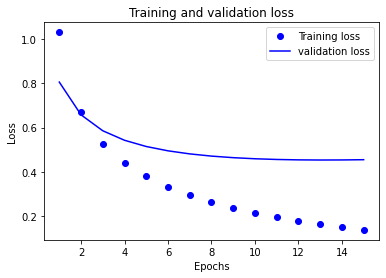

In [127]:
plt.plot(epochs, loss, 'bo', label='Training loss') # bo stands for "blue dot"
plt.plot(epochs, val_loss, 'b', label='validation loss') # b stands for "blue"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

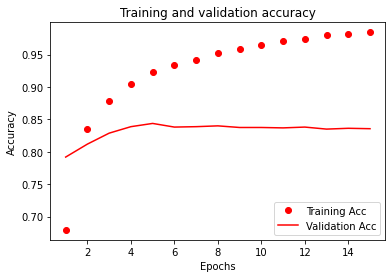

In [128]:
# Same plotting for the accuracy
plt.plot(epochs, acc, 'ro', label='Training Acc') # bo stands for "blue dot"
plt.plot(epochs, val_acc, 'r', label='Validation Acc') # b stands for "blue"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [130]:
# Export the model for the production use
Model_for_inference = tf.keras.Sequential([binary_vectorize_layer, model, layers.Activation('sigmoid')])

In [131]:
Model_for_inference.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

In [132]:
loss_I, accuracy_I = Model_for_inference.evaluate(raw_test_ds)

500/500 [==============================] - 2s 4ms/step - loss: 0.4885 - accuracy: 0.8077


In [133]:
# inferencing on new data
def get_predicted_labels(predicted_scores_batch):
    predicted_int_labels = tf.argmax(predicted_scores_batch, axis=1)
    predicted_labels = tf.gather(raw_train_ds.class_names, predicted_int_labels)
    
    return predicted_labels

In [142]:
examples = [
    
 "How do I extract keys from a dict into a list?", # PYTHON
 "debug public static void main(string[] args) { print('Hello world') }", # JAVA
 "console.log('Hello JS')",
    
]

In [143]:
predicted_scores = Model_for_inference.predict(examples)

In [144]:
predicted_labels = get_predicted_labels(predicted_scores)

In [145]:
predicted_scores

array([[0.31114334, 0.15037876, 0.15058216, 0.8972307 ],
       [0.72772735, 0.7893473 , 0.01229784, 0.02828315],
       [0.2437532 , 0.2512433 , 0.83536154, 0.14561847]], dtype=float32)

In [146]:
predicted_labels

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'python', b'java', b'javascript'], dtype=object)>

In [147]:
for example, label in zip(examples, predicted_labels):
    print("question: ", example)
    print("Predicted label;", label.numpy())

question:  How do I extract keys from a dict into a list?
Predicted label; b'python'
question:  debug public static void main(string[] args) { print('Hello world') }
Predicted label; b'java'
question:  console.log('Hello JS')
Predicted label; b'javascript'
